In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_sig,n_samples,out_sig=None):
    plt.figure()
    plt.subplot(1,1,1)
    plt.xlabel('Time(usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_sig[:n_samples],'b-',label='Input signal')
    if out_sig is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_sig[:n_samples],'g-',linewidth=2,label='FIR output')
    plt.legend()


Number os samples:  200000


<IPython.core.display.Javascript object>


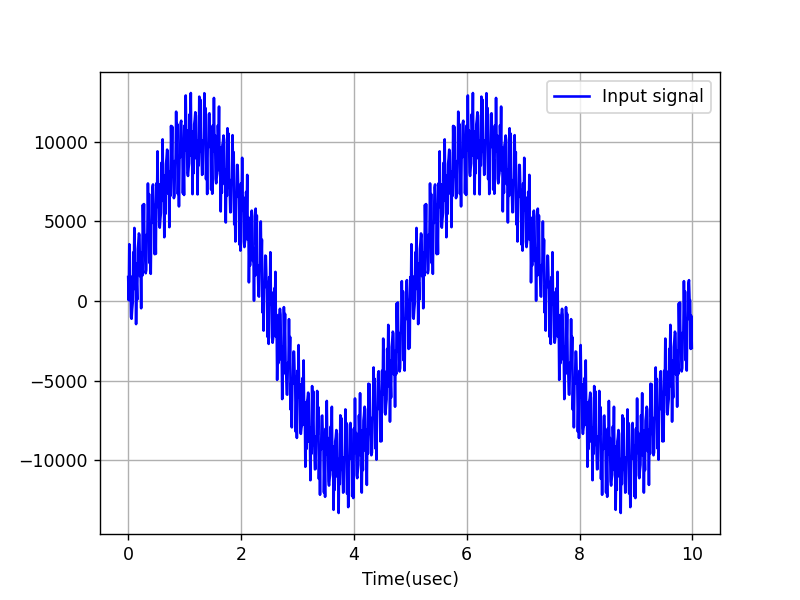

In [2]:
import numpy as np
T=0.002
fs=100e6
n=int(T*fs)
t=np.linspace(0,T,n,endpoint=False)
samples=10000*np.sin(0.2e6*2*np.pi*t)+1500*np.cos(46e6*2*np.pi*t)+2000*np.sin(12e6*2*np.pi*t)
samples=samples.astype(np.int32)
print('Number os samples: ',len(samples))
plot_to_notebook(t,samples,1000)


Software FIR execution time:  0.04221177101135254


<IPython.core.display.Javascript object>


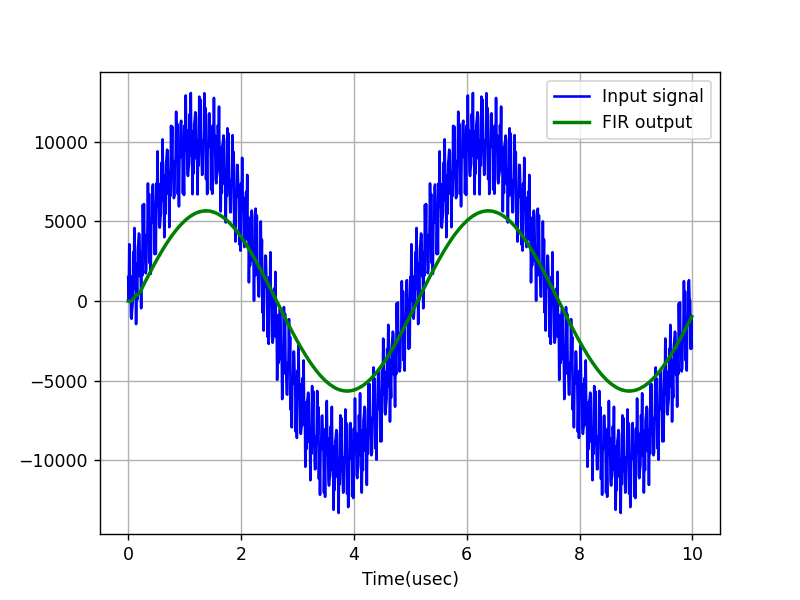

In [3]:
from scipy.signal import lfilter
coeffs=[-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

import time
start_time=time.time()
sw_fir_output=lfilter(coeffs,70e3,samples)
stop_time=time.time()
sw_exec_time=stop_time-start_time
print('Software FIR execution time: ',sw_exec_time)

plot_to_notebook(t,samples,1000,out_sig=sw_fir_output)

In [4]:
from pynq import Overlay
import pynq.lib.dma

handle=Overlay("FIR.bit")
dma=handle.filter.fir_dma

In [5]:
from pynq import allocate
import numpy as np

in_buffer=allocate(shape=(n,),dtype=np.int32)
out_buffer=allocate(shape=(n,),dtype=np.int32)

In [6]:
np.copyto(in_buffer,samples)
print(in_buffer)

[ 1500    41  3561 ... -3011  -932 -2947]


In [7]:
import time
start_time=time.time()

In [8]:
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.recvchannel.wait()

In [9]:
stop_time=time.time()
hw_exec_time=stop_time-start_time
print('HW FIR execution time: ',hw_exec_time)
print('HW acceleration factor: ',sw_exec_time/hw_exec_time)

HW FIR execution time:  3.0068931579589844
HW acceleration factor:  0.014038334185443755


<IPython.core.display.Javascript object>


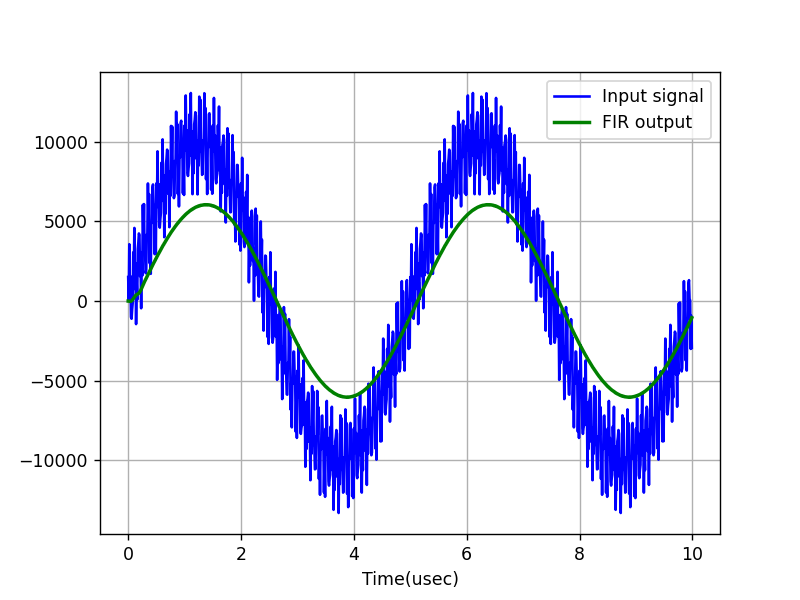

In [10]:
plot_to_notebook(t,samples,1000,out_sig=out_buffer)

in_buffer.close()
out_buffer.close()